In [2]:
import sklearn.datasets as ds 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, gaussian_kde

# Task 1

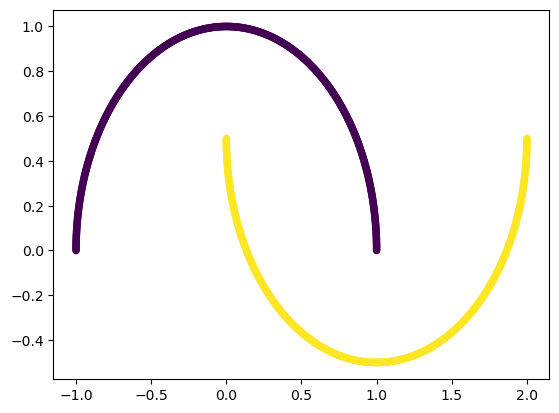

In [15]:
N=1000
data=ds.make_moons(N)
dataset=np.array(data[0])
X=dataset[:,0]
Y=dataset[:,1]
label=np.array(data[1])

plt.scatter(X,Y,c=label,s=20)



In [13]:
### decompose 2D histogram
def cdf_histogram(dataset,binsize):
    X=dataset[:,0]
    Y=dataset[:,1]
    xmin=np.min(X)
    ymin=np.min(Y) #with an offset the upper and lower limits of the histogram can be extended which may improve the quality the generation at the upper and lower end of the data
    xmax=np.max(X)
    ymax=np.max(Y)
    Nx=np.round((xmax-xmin)/binsize) #Number of bins
    Ny=np.round((ymax-ymin)/binsize) 
    binx=np.linspace(xmin,xmax,int(Nx)) 
    biny=np.linspace(ymin,ymax,int(Ny))
    ### p(x1)
    # numpy histogram just for X coordinate
    p1, binx=np.histogram(X, binx)
    p1=p1/N   #normalize
    cdfx=np.cumsum(p1) #create CDF

    ### p(x2|x1) -> for every x1 bin one distribution
    # for every bin create numpy histogram for Y
    #create CDFs^-1 (picewise linear function)

    bin_indices={}
    # Loop over every bin of X histogram:
    for i in range(1, len(binx)):
        # Indices of each element x in bin number i 
        indices = np.where((binx[i-1] <= X) & (X < binx[i]))[0]
        bin_indices[i] = indices
        
    
    


    Ys ={}

    for bin, indices in bin_indices.items():
        Ys[bin] =Y[indices]
    cdfy = {}
    for i in Ys:
        p2, biny=np.histogram(Ys[i], biny)
        p2=p2/np.sum(p2)   #normalize
        cdfy[i]=np.cumsum(p2)#create CDF
    
    cdfy = np.vstack(list(cdfy.values()))

    ### We need a little rising offset for the histogramms for better data generation:
    for i in range(cdfy.shape[0]):
        # Loop through the entries of the inside arrays
        offset=0
        for j in range(cdfy.shape[1]):
            # Add the offset to each entry
            cdfy[i, j] += offset 
            # Increase the offset
            offset += 0.0000001
    return cdfx,cdfy,binx,biny  

<div style="color: green; font-weight: bold">
Variable names could be more descriptive, providing clearer insights into their roles in the code.

If you use np.histogram, consider just using np.2dhistogram. It would be faster and more readable.
</div>

In [17]:

def find_nearest(array, value):
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()


In [5]:
### GMM 2d model
def gaussian(x, mean, cov):
    k = len(mean)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * np.dot(np.dot((x - mean).T, inv_cov), (x - mean))
    coefficient = 1 / ((2 * np.pi) ** (k / 2) * det_cov ** 0.5)
    return coefficient * np.exp(exponent)

def initialize_parameters(data, num_components):
    num_samples, num_features = data.shape
    # Randomly initialize means
    means = data[np.random.choice(num_samples, num_components, replace=False)]
    # Initialize covariances
    covariances = [np.cov(data.T) for _ in range(num_components)]
    # Set uniform weights initially
    weights = np.ones(num_components) / num_components
    return means, covariances, weights
def expectation_maximization(data, num_components, num_iterations=100):

    means, covariances, weights = initialize_parameters(data, num_components)

    for iteration in range(num_iterations):
        # E-step
        importance = np.zeros((len(data), num_components))
        for i in range(num_components):
            importance[:, i] = weights[i] * np.apply_along_axis(gaussian, 1, data, means[i], covariances[i])

        importance /= importance.sum(axis=1, keepdims=True)

        # M-step
        for i in range(num_components):
            Nk = importance[:, i].sum()
            weights[i] = Nk / len(data)
            means[i] = np.dot(importance[:, i], data) / Nk
            covariances[i] = np.dot(importance[:, i] * (data - means[i]).T, (data - means[i])) / Nk
    return means, covariances, weights



<div style="color: green; font-weight: bold">
Consider replacing num_features and iteration with _ as it is not used and that variable naming would indicate that. Also concerning readability, please insert an empty line between the initialization and expectation maximization function. 

Since you are already using a function that is basically named init, you could consider using classes like in the Worked Example. 
</div>

In [7]:
# Define the squared exponential (SE) kernel function
def se_kernel(x, y, sigma=1.0):
    distance = np.linalg.norm(x - y)
    return np.exp(-0.5 * (distance / sigma) ** 2)

In [5]:
def kernel_density_estimate(x, data, sigma=1.0):
    n = len(data)
    total_kernel_value = sum(se_kernel(x, data[i], sigma) for i in range(n))
    return total_kernel_value / (n * (2 * np.pi * sigma**2)**(len(x) / 2))



In [6]:
def imq_kernel(x, y, sigma=1.0):
    distance = np.linalg.norm(x - y)
    return 1/((distance / sigma) ** 2 +1)

   

<div style="color: green; font-weight: bold">
Your code is really good, the only thing we can critizise is again readability. It is a bit confusing that you first define a kernel, then the KDE and then another kernel. 
</div>

In [8]:
# Compute the MMD 
def compute_mmd(data_1, data_2, kernel=se_kernel, sigma=1.0):
    m = len(data_1)
    n = len(data_2)

    # Compute the MMD^2 statistic
    XX = 0.0
    YY = 0.0
    XY= 0.0

    for i in range(m):
        for j in range(m):
            XX += kernel(data_1[i], data_1[j], sigma)
    XX = XX/(m*(m-1))
    for i in range(n):
        for j in range(n):
            YY += kernel(data_2[i], data_2[j], sigma)
    YY = YY/(n*(n-1))
    for i in range(m):
        for j in range(n):
            XY += kernel(data_1[i], data_2[j], sigma)
    XY = XY/(m*n)
    
    mmd_squared=XX+YY-2*XY
    return np.sqrt(mmd_squared)
    """kernel_XY = kernel(data1, data2,sigma)
    kernel_XX = kernel(data1, data1,sigma)
    kernel_YY = kernel(data2, data2,sigma)

    return np.sqrt(np.mean(kernel_XX) - 2 * np.mean(kernel_XY) + np.mean(kernel_YY))"""

<div style="color: green; font-weight: bold">
Structurally I think it makes more sense to show example plots of your models after introducing your models and thereby before the MMD. 

...
</div>

In [19]:
### Testset

N2=250
test=ds.make_moons(N2)
Testset=np.array(test[0])




/var/folders/xm/qnmpmpfn4k9gsr6mycrzv8_40000gn/T/ipykernel_36509/1121887197.py:41: RuntimeWarning: invalid value encountered in divide
  p2=p2/np.sum(p2)   #normalize


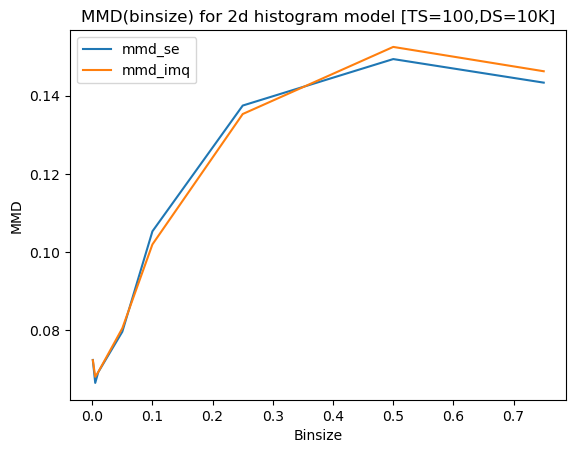

In [21]:

### MMD 2dhistogram
binsize=np.array([0.001,0.005,0.01,0.05,0.1,0.25,0.5,0.75])

mmdse=np.empty((binsize.shape[0],2))
mmdimq=np.empty((binsize.shape[0],2))
for i in range(binsize.shape[0]):
    cdfx,cdfy,binx,biny=cdf_histogram(dataset,binsize[i])
    generated_data=np.empty((N2,2))
    for j in range(N2):    
        random_x=np.random.uniform(0,1)
        random_y=np.random.uniform(0,1)
        ppf_x=find_nearest(cdfx, random_x)
        generated_x=np.random.uniform(binx[ppf_x],binx[ppf_x+1])
        ppf_y=find_nearest(cdfy[ppf_x], random_y)
        generated_y=np.random.uniform(biny[ppf_y],biny[ppf_y+1])
        generated_data[j]=np.array([generated_x,generated_y])
    mmdse[i]=binsize[i],compute_mmd(generated_data, Testset,sigma=0.05)
    mmdimq[i]=binsize[i],compute_mmd(generated_data, Testset,kernel=imq_kernel, sigma=0.05)
    plt.title("MMD(binsize) for 2d histogram model [TS=100,DS=10K]")
    plt.xlabel("Binsize")
    plt.ylabel("MMD")
plt.plot(mmdse[:,0],mmdse[:,1],label="mmd_se")  
plt.plot(mmdimq[:,0],mmdimq[:,1],label="mmd_imq") 
plt.legend()
 

Type of increase depends on Bandwith of Kernel in MMD.
But the best results are always achieved for the smallest binsize. Which is quite intuitive because the "resolutiuon" of the 2d histogram gets better for smaller binsizes and therefore depicts the true pdf better.
It takes longer to calculate histogram for smallerbinsizes because there are more histogramms/cdfs to be calculated in the end.
The MMD with squared exp kernel and inverse multi-quad kernel achieves quite similar results. The model is also fast for bigger datasets. For to small values (<0.005) the MMD rises a little bit again.

For smaller datasets the results are also very similar. However the relation between dataset size and calculation is not that strong.

In [12]:

### MMD Single Gaussian
# Fit a single Gaussian distribution to the data
mean = np.mean(dataset, axis=0)
cov = np.cov(dataset.T)
gaussian2 = multivariate_normal(mean=mean, cov=cov)
generated_data = gaussian2.rvs(size=N2)

print("MMD for single Gaussian Modell:")
print("SE: ",compute_mmd(generated_data, Testset,sigma=0.05))
print("IMQ: ",compute_mmd(generated_data, Testset,kernel=imq_kernel, sigma=0.05))


MMD for single Gaussian Modell:
SE:  0.14551119267268461
IMQ:  0.14529972384889184


Results are really bad and can be compared to results of 2d histogram with high binsizes. IMQ and SE results are quite the same.

In [13]:
def generate_gmm_data(num_samples, means, covariances, weights):

    num_components = len(means)
    data = np.zeros((num_samples, len(means[0])))

    # Sample from each component based on weights
    for i in range(num_samples):
        component = np.random.choice(num_components, p=weights)
        data[i, :] = np.random.multivariate_normal(means[component], covariances[component])

    return data


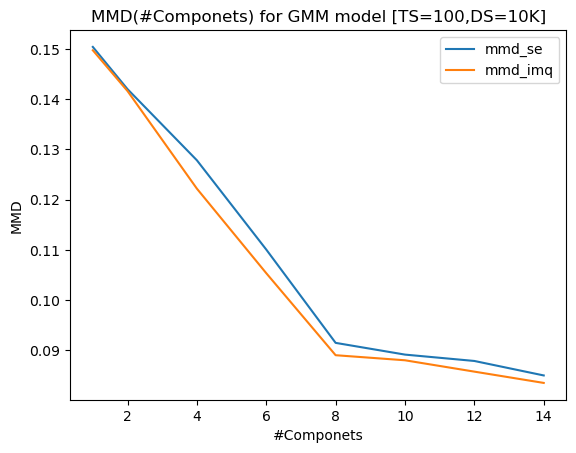

In [14]:
### GMM
l=np.array([1,2,4,6,8,10,12,14])
mmdse=np.empty((l.shape[0],2))
mmdimq=np.empty((l.shape[0],2))
for i in range(l.shape[0]):
    means, covariances, weights = expectation_maximization(dataset, l[i],num_iterations=100)
    generated_data = generate_gmm_data(N2, means, covariances, weights)
    mmdse[i]=l[i],compute_mmd(generated_data, Testset,sigma=0.05)
    mmdimq[i]=l[i],compute_mmd(generated_data, Testset,kernel=imq_kernel, sigma=0.05)
    plt.title("MMD(#Componets) for GMM model [TS=100,DS=10K]")
    plt.xlabel("#Componets")
    plt.ylabel("MMD")
plt.plot(mmdse[:,0],mmdse[:,1],label="mmd_se")  
plt.plot(mmdimq[:,0],mmdimq[:,1],label="mmd_imq") 
plt.legend()

First of all the calculation of the model takes overall longer than for the 2dhistogram model. Results get better for more components. However there often is a sweet spot (at around 8-10 components). When reducing the iterations results get worse. 100 seems to be a good number. For bigger datasets the calculation also takes much longer.  

In [15]:
#Load smaller dataset for Kde
N3=100
data2=ds.make_moons(N3)
dataset2=np.array(data2[0])
X2=dataset2[:,0]
Y2=dataset2[:,1]


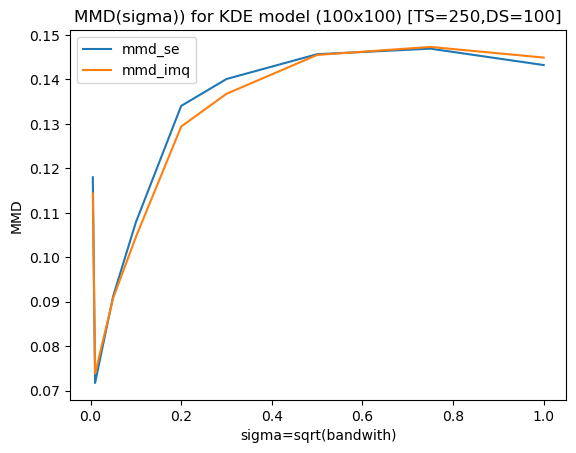

In [16]:
### KDE


sigma=np.array([0.005,0.01,0.05,0.1,0.2,0.3,0.5,0.75,1])
mmdse=np.empty((sigma.shape[0],2))
mmdimq=np.empty((sigma.shape[0],2))
# Create a grid for the density estimate
x_grid, y_grid = np.meshgrid(np.linspace(X2.min(), X2.max(), 100),np.linspace(Y2.min(), Y2.max(), 100))


for k in range(sigma.shape[0]):
    # Compute the kernel density estimate at each point on the grid
    density_estimate = np.zeros_like(x_grid)
    for i in range(x_grid.shape[0]):
        
        for j in range(x_grid.shape[1]):
            point = np.array([x_grid[i, j], y_grid[i, j]])
            density_estimate[i, j] = kernel_density_estimate(point, dataset2, sigma[k])
    # Reshape the density estimate for sampling
    density_flat = density_estimate.flatten()
    density_flat /= density_flat.sum()

    # Flatten the grids for sampling
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()

    # Sample new data points based on the kernel density estimate
    sampled_indices = np.random.choice(len(x_flat), size=N2, p=density_flat)
    generated_data = np.column_stack((x_flat[sampled_indices], y_flat[sampled_indices]))

    # Add randomness to the placement of points within each grid cell
    cell_size_x = np.diff(x_grid[0, :])[0]
    cell_size_y = np.diff(y_grid[:, 0])[0]

    generated_data[:, 0] += np.random.uniform(-cell_size_x / 2, cell_size_x / 2, size=N2)
    generated_data[:, 1] += np.random.uniform(-cell_size_y / 2, cell_size_y / 2, size=N2)
    
    mmdse[k]=sigma[k],compute_mmd(generated_data, Testset,sigma=0.05)
    mmdimq[k]=sigma[k],compute_mmd(generated_data, Testset,kernel=imq_kernel, sigma=0.05)
plt.title("MMD(sigma)) for KDE model (100x100) [TS=250,DS=100]")
plt.xlabel("sigma=sqrt(bandwith)")
plt.ylabel("MMD")
plt.plot(mmdse[:,0],mmdse[:,1],label="mmd_se")  
plt.plot(mmdimq[:,0],mmdimq[:,1],label="mmd_imq") 
plt.legend()

There is an optimum at 0.01 as value for sigma. For smaller values the MMD gets significantly higher (for 0.001 and 25x25 its around 0.25). These values are ignored in the diagramm for visulization purposes. For higgher values of sigma the MMD gets higher. The rise can be compared with the 2d histogramm model. We also found that the optimum is related to the gridsize of the KDE: smaller gridsize->smaller optimum sigma. However smaller gridsize also means longer calculation time. The minimum MMD fo 100x100 was smaller (0.06) compared to 25x25 (0.08). The results for datasets of 250 and 100 are quite the same. But calculation for 250 take much longer compared to the one second increase for 2dhistogram. For 1000 datapoints the results are slightly better.

We will now present the following 6 Models:



1. Big binsize 2dhistogram:

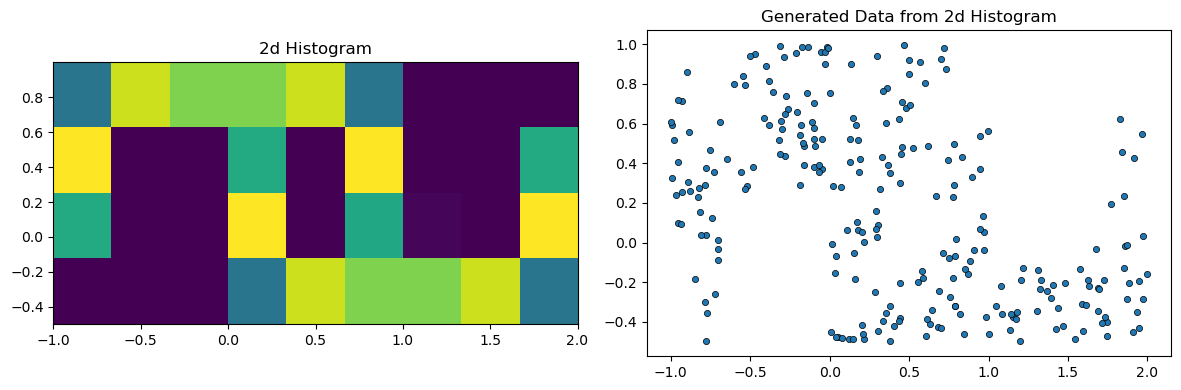

In [17]:
binsize=0.3

X=dataset[:,0]
Y=dataset[:,1]
xmin=np.min(X)
ymin=np.min(Y) #with an offset the upper and lower limits of the histogram can be extended which may improve the quality the generation at the upper and lower end of the data
xmax=np.max(X)
ymax=np.max(Y)
Nx=np.round((xmax-xmin)/binsize) #Number of bins
Ny=np.round((ymax-ymin)/binsize) 
binx=np.linspace(xmin,xmax,int(Nx)) 
biny=np.linspace(ymin,ymax,int(Ny))

h, xedges, yedges=np.histogram2d(X,Y,[binx,biny]) # numpy function to create 2d histogram
h=h/N

cdfx,cdfy,binx,biny=cdf_histogram(dataset,binsize)
generated_data=np.empty((N2,2))

for j in range(N2):    
    random_x=np.random.uniform(0,1)
    random_y=np.random.uniform(0,1)
    ppf_x=find_nearest(cdfx, random_x)
    generated_x=np.random.uniform(binx[ppf_x],binx[ppf_x+1])
    ppf_y=find_nearest(cdfy[ppf_x], random_y)
    generated_y=np.random.uniform(biny[ppf_y],biny[ppf_y+1])
    generated_data[j]=np.array([generated_x,generated_y])


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot data on the first subplot
axes[0].imshow(h.T, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
axes[0].set_title('2d Histogram')


# Plot data on the second subplot
axes[1].scatter(generated_data[:,0],generated_data[:,1],s=20,edgecolors='k', linewidth=0.5)
axes[1].set_title("Generated Data from 2d Histogram")

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

This is not a good PDF estimate. You can recognize the shape at the left and right but in the middle the resolution of the histogram is to low to strictly distinguish the two sickles. However when looking at the calculation effort and overall result the model proves itself to be a good first approximation when just improving the the resolution. 

2. Small binsize 2dhistogram:

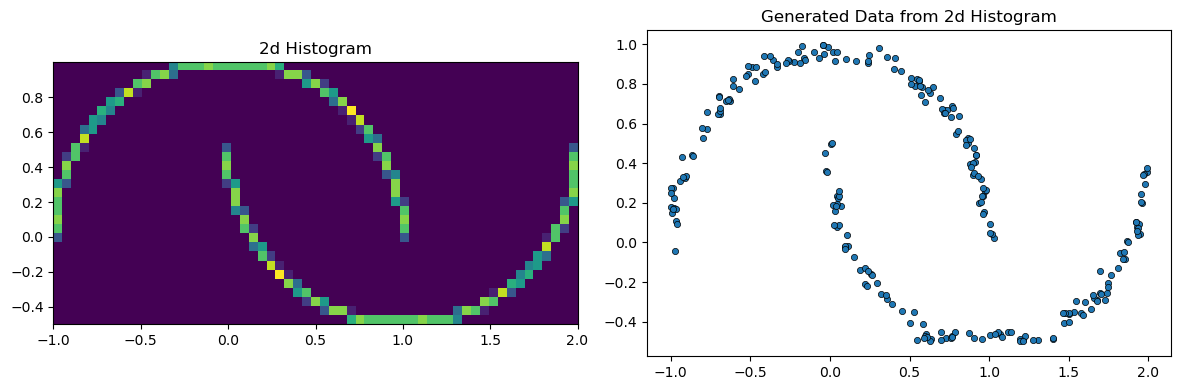

In [18]:
binsize=0.05

X=dataset[:,0]
Y=dataset[:,1]
xmin=np.min(X)
ymin=np.min(Y) #with an offset the upper and lower limits of the histogram can be extended which may improve the quality the generation at the upper and lower end of the data
xmax=np.max(X)
ymax=np.max(Y)
Nx=np.round((xmax-xmin)/binsize) #Number of bins
Ny=np.round((ymax-ymin)/binsize) 
binx=np.linspace(xmin,xmax,int(Nx)) 
biny=np.linspace(ymin,ymax,int(Ny))

h, xedges, yedges=np.histogram2d(X,Y,[binx,biny]) # numpy function to create 2d histogram
h=h/N

cdfx,cdfy,binx,biny=cdf_histogram(dataset,binsize)
generated_data=np.empty((N2,2))

for j in range(N2):    
    random_x=np.random.uniform(0,1)
    random_y=np.random.uniform(0,1)
    ppf_x=find_nearest(cdfx, random_x)
    generated_x=np.random.uniform(binx[ppf_x],binx[ppf_x+1])
    ppf_y=find_nearest(cdfy[ppf_x], random_y)
    generated_y=np.random.uniform(biny[ppf_y],biny[ppf_y+1])
    generated_data[j]=np.array([generated_x,generated_y])


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot data on the first subplot
axes[0].imshow(h.T, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
axes[0].set_title('2d Histogram')


# Plot data on the second subplot
axes[1].scatter(generated_data[:,0],generated_data[:,1],s=20,edgecolors='k', linewidth=0.5)
axes[1].set_title("Generated Data from 2d Histogram")

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

This seems to be a really good estaimate of the PDF. There are some corners so the resulting pdf is not smooth but when improving the resolution the function will get smoother (more data needed at some point.) The calculation time was really fast.

3. Single Gaussian distribution

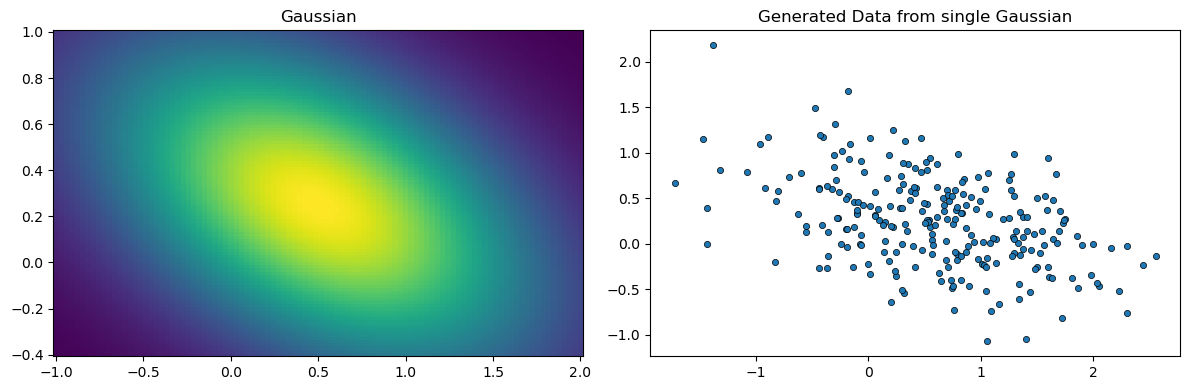

In [19]:
# Fit a single Gaussian distribution to the data
mean = np.mean(dataset, axis=0)
cov = np.cov(dataset.T)
single_gaussian = multivariate_normal(mean=mean, cov=cov)

generated_data = single_gaussian.rvs(size=N2) # From now on we use .rvs which works similar to the CDF method from the 2d histogram model



x, y = np.meshgrid(np.linspace(-1, 2, 100), np.linspace(-0.4, 1, 100))
positions = np.column_stack((x.ravel(), y.ravel()))

pdf_values=single_gaussian.pdf(positions)
pdf_values = pdf_values.reshape(100, 100)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot data on the first subplot
axes[0].pcolormesh(x, y, pdf_values, cmap='viridis', shading='auto')
axes[0].set_title('Gaussian')


# Plot data on the second subplot
axes[1].scatter(generated_data[:, 0], generated_data[:, 1], s=20,edgecolors='k', linewidth=0.5)
axes[1].set_title("Generated Data from single Gaussian")

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

This model is a worse estaimate. The model could only work if the real pdf would have one peak and a more ore less gaussian/symmetrical decline. For our small and distinct PDF this model acheives no good estimate.

4. GMM with 4 Componets

/var/folders/bb/g3q2w6x55bsfk58389k938g00000gn/T/ipykernel_75095/2337649620.py:30: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = plt.matplotlib.patches.Ellipse(


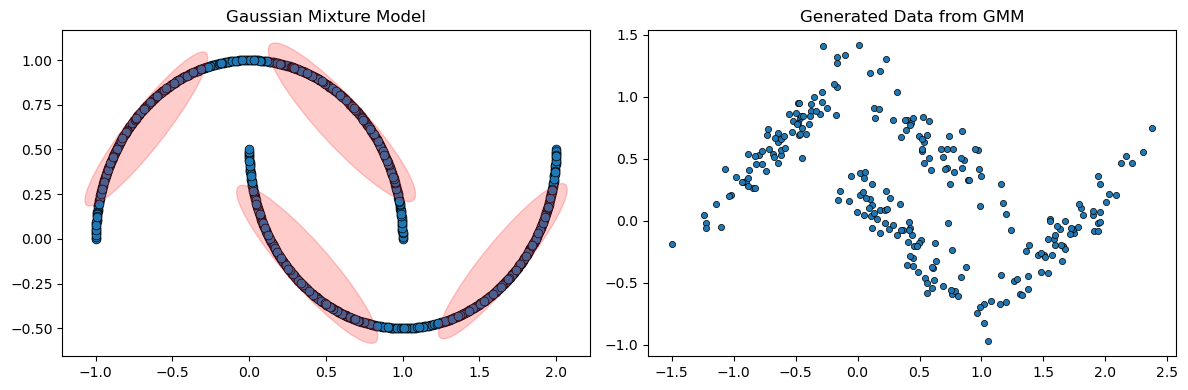

In [20]:
l=4 #Number of components
#Do EM to learn the components of the GMM
means, covariances, weights = expectation_maximization(dataset, l)
# Generate synthetic data

generated_data = generate_gmm_data(N2, means, covariances, weights)



fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot data on the first subplot
axes[0].scatter(dataset[:, 0], dataset[:, 1], s=40, edgecolors='k', linewidth=0.5)
axes[0].set_title("Gaussian Mixture Model")


# Plot data on the second subplot
axes[1].scatter(generated_data[:, 0], generated_data[:, 1], s=20,edgecolors='k', linewidth=0.5)
axes[1].set_title("Generated Data from GMM")

for i in range(len(means)):
    mean = means[i]
    covariance = covariances[i]
    v, w = np.linalg.eigh(covariance)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])

    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = plt.matplotlib.patches.Ellipse(
        mean, v[0], v[1], 180.0 + angle, color='r', alpha=0.2)
    axes[0].add_patch(ell)


# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()


Sometimes this model depending on the random start values, aproximates the overall distribution good and distinguishes the two sickels but fails to estimate the round shape of the true PDF. However it sometimes fits one big gaussian in the middle or somewehere else and tries to combines the two sickels wich results in a bad estimate. Sometimes the estaimte is also really bad because some gaussians are fitted way to big. These are quite the same problems from the single gaussain if the model tries to estimate a PDF with two or more peaks. 

5. GMM with 8 components

/var/folders/bb/g3q2w6x55bsfk58389k938g00000gn/T/ipykernel_75095/1393727382.py:30: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = plt.matplotlib.patches.Ellipse(


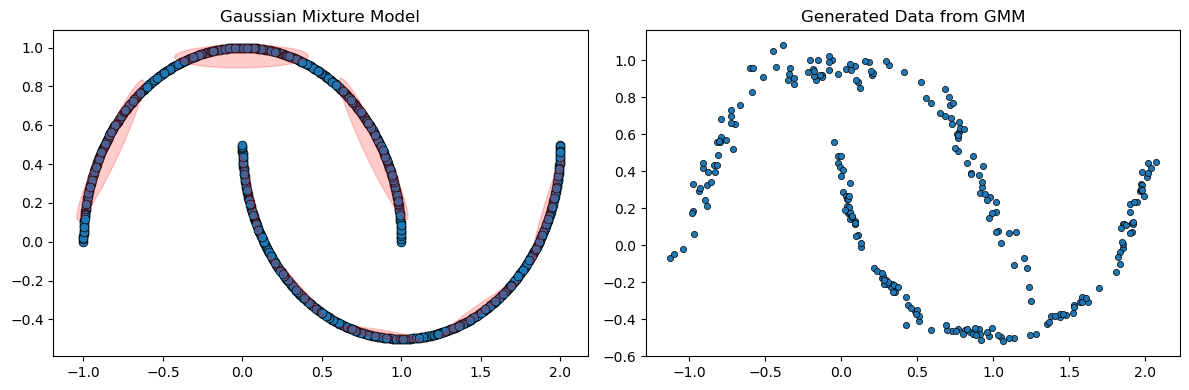

In [21]:
l=8 #Number of components
#Do EM to learn the components of the GMM
means, covariances, weights = expectation_maximization(dataset, l)
# Generate synthetic data

generated_data = generate_gmm_data(N2, means, covariances, weights)



fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot data on the first subplot
axes[0].scatter(dataset[:, 0], dataset[:, 1], s=40, edgecolors='k', linewidth=0.5)
axes[0].set_title("Gaussian Mixture Model")


# Plot data on the second subplot
axes[1].scatter(generated_data[:, 0], generated_data[:, 1], s=20,edgecolors='k', linewidth=0.5)
axes[1].set_title("Generated Data from GMM")

for i in range(len(means)):
    mean = means[i]
    covariance = covariances[i]
    v, w = np.linalg.eigh(covariance)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])

    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = plt.matplotlib.patches.Ellipse(
        mean, v[0], v[1], 180.0 + angle, color='r', alpha=0.2)
    axes[0].add_patch(ell)


# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()


With 8 componets the estiamte is pretty good, however it still fails to estimate the round shape which seems to be a characteristic of the GMM. The calculation time was quite high.

6. KDE with SE Kernel for 100x100 Grid and Sigma=0.01 

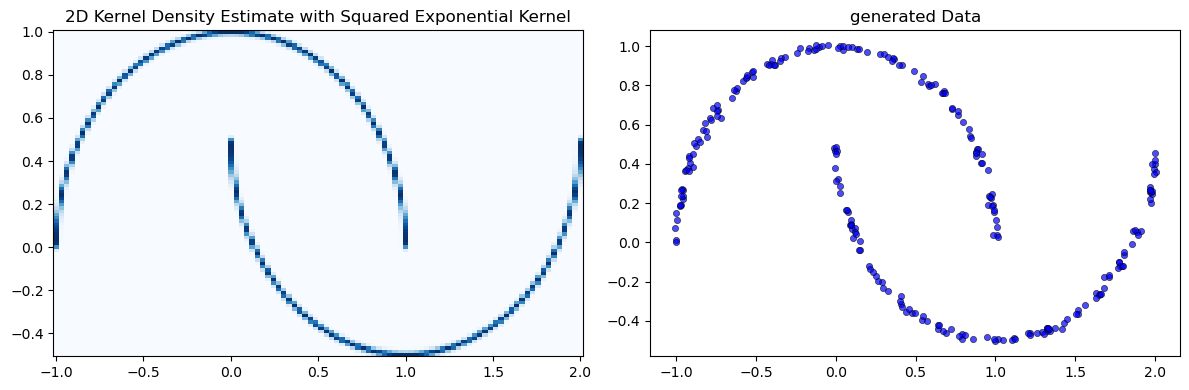

In [22]:
bandwith=0.01 #this is sigma=sqrt(bandwith)

# Create a grid for the density estimate
x_grid, y_grid = np.meshgrid(np.linspace(X2.min(), X2.max(), 100),np.linspace(Y2.min(), Y2.max(), 100))

# Compute the kernel density estimate at each point on the grid
density_estimate = np.zeros_like(x_grid)



for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        point = np.array([x_grid[i, j], y_grid[i, j]])
        density_estimate[i, j] = kernel_density_estimate(point, dataset, bandwith)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))


# Plot data on the first subplot
axes[0].pcolormesh(x_grid, y_grid, density_estimate, cmap='Blues', shading='auto')
axes[0].set_title("2D Kernel Density Estimate with Squared Exponential Kernel")



# Reshape the density estimate for sampling
density_flat = density_estimate.flatten()
density_flat /= density_flat.sum()

# Flatten the grids for sampling
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Sample new data points based on the kernel density estimate

sampled_indices = np.random.choice(len(x_flat), size=N2, p=density_flat)
sampled_points = np.column_stack((x_flat[sampled_indices], y_flat[sampled_indices]))

# Add randomness to the placement of points within each grid cell
cell_size_x = np.diff(x_grid[0, :])[0]
cell_size_y = np.diff(y_grid[:, 0])[0]

sampled_points[:, 0] += np.random.uniform(-cell_size_x / 2, cell_size_x / 2, size=N2)
sampled_points[:, 1] += np.random.uniform(-cell_size_y / 2, cell_size_y / 2, size=N2)



# Plot data on the second subplot
axes[1].scatter(sampled_points[:, 0], sampled_points[:, 1], s=20, color='blue', alpha=0.7,edgecolors='k', linewidth=0.5)
axes[1].set_title("generated Data")
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

This is the best model so far. There are many similarities to the 2dhistogramm but the resulting PDFs are much smoother/rounder. The thin shape of the sickels could be very good aproximated with small bandwith. However this model took a long time to be calculated.

7. KDE with to small sigma

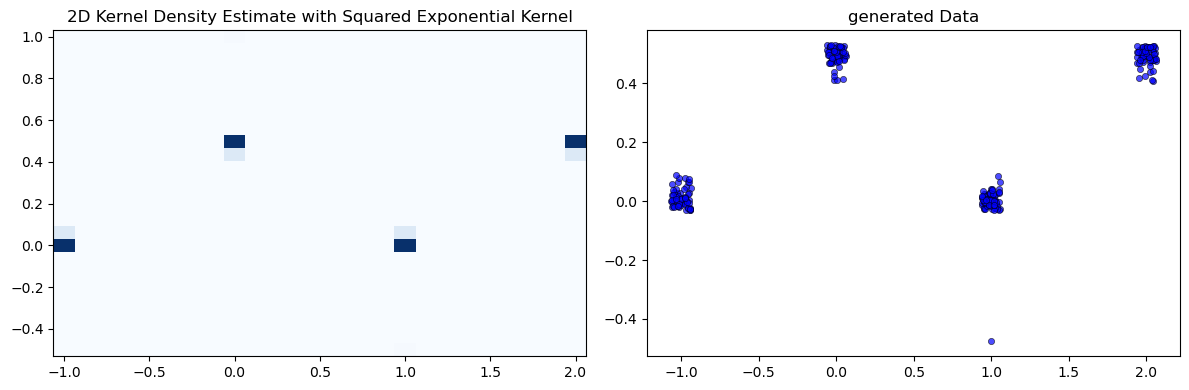

In [23]:
bandwith=0.001 #this is sigma=sqrt(bandwith)

# Create a grid for the density estimate
x_grid, y_grid = np.meshgrid(np.linspace(X2.min(), X2.max(), 25),np.linspace(Y2.min(), Y2.max(), 25))

# Compute the kernel density estimate at each point on the grid
density_estimate = np.zeros_like(x_grid)



for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        point = np.array([x_grid[i, j], y_grid[i, j]])
        density_estimate[i, j] = kernel_density_estimate(point, dataset, bandwith)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))


# Plot data on the first subplot
axes[0].pcolormesh(x_grid, y_grid, density_estimate, cmap='Blues', shading='auto')
axes[0].set_title("2D Kernel Density Estimate with Squared Exponential Kernel")



# Reshape the density estimate for sampling
density_flat = density_estimate.flatten()
density_flat /= density_flat.sum()

# Flatten the grids for sampling
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Sample new data points based on the kernel density estimate

sampled_indices = np.random.choice(len(x_flat), size=N2, p=density_flat)
sampled_points = np.column_stack((x_flat[sampled_indices], y_flat[sampled_indices]))

# Add randomness to the placement of points within each grid cell
cell_size_x = np.diff(x_grid[0, :])[0]
cell_size_y = np.diff(y_grid[:, 0])[0]

sampled_points[:, 0] += np.random.uniform(-cell_size_x / 2, cell_size_x / 2, size=N2)
sampled_points[:, 1] += np.random.uniform(-cell_size_y / 2, cell_size_y / 2, size=N2)



# Plot data on the second subplot
axes[1].scatter(sampled_points[:, 0], sampled_points[:, 1], s=20, color='blue', alpha=0.7,edgecolors='k', linewidth=0.5)
axes[1].set_title("generated Data")
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

To conclude: for both 2dhistogram and KDE we reach a minimum MMD for a testset of 250. The calculations take way longer for KDE than for 2dhistogram, especially for bigger datasets. However with KDE the roundness and thickness of the true PDF can be estaimted more precice. The single gaussian results in a MMD similar to the worst of the other models. This is due to the far away from gaussian shape of our true PDF. There are only worse MMDs for way to small sigams in KDE which result in really concentrated estimates. The GMM achieves good MMDs at around 8-10 components for less components it struggels. For more components it seems as if the GMM improves, however this takes much time to calculate. The best results were achieved by KDE and 2d histograms. The latter is faster but the KDE can be controlled more precise.

<div style="color: green; font-weight: bold">
Nice work! It is very nice to show both the desnity plot and generation plot respectively. Personally, combined graphs as the working example would be more preferred, and you don't have to do that much copy-paste work.
</div>

# Task 2

In [60]:
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture


digits = load_digits()
X, y = digits.data, digits.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("RFC Accuracy on Original Dataset:", accuracy)

# Generate synthetic data from a Gaussian Mixture Model (GMM) as an example
# 1. Train a GMM on the original dataset
gmm = GaussianMixture(n_components=63, random_state=42)
gmm.fit(X)

# 2. Generate synthetic data from the GMM
generated_data = gmm.sample(n_samples=360)[0]

# Classify the generated data using rf_classifier
generated_data_pred = rf_classifier.predict(generated_data)

# Evaluate the accuracy of the generated data using the same classifier
accuracy_generated = accuracy_score(y_test, generated_data_pred)
print("Accuracy of Generated Data (GMM):", accuracy_generated)

RFC Accuracy on Original Dataset: 0.9722222222222222
Accuracy of Generated Data (GMM): 0.13333333333333333


GMM does not fit the data well. 10 components: ~6%
63 components: ~13%

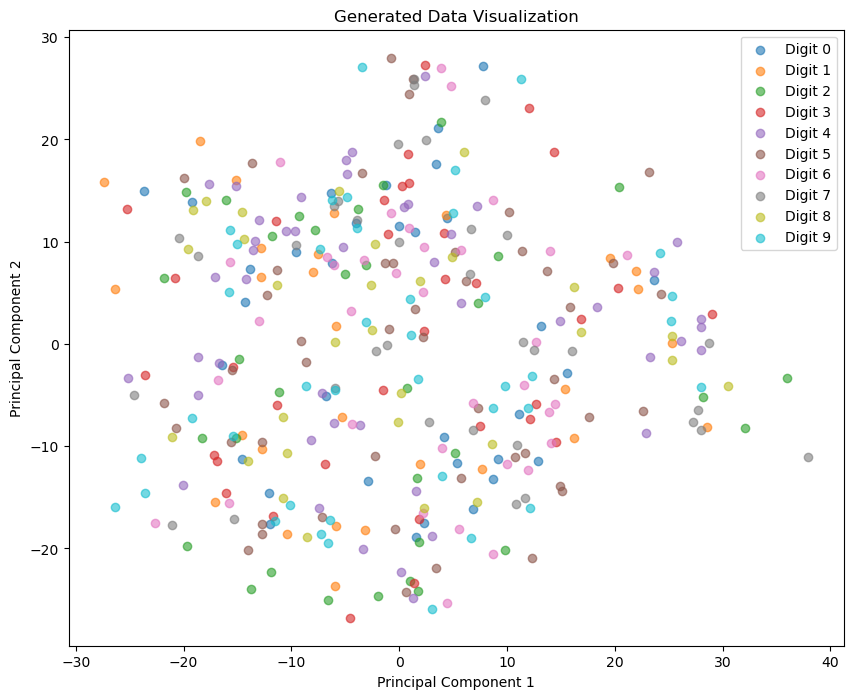

In [54]:
from sklearn.decomposition import PCA

# Visualize the generated data using PCA
pca = PCA(n_components=2)  # Reduce to 2D for visualization
reduced_data = pca.fit_transform(generated_data)  # Apply PCA to the generated data

# Create a scatter plot to visualize the data
plt.figure(figsize=(10, 8))
for digit in range(10):
    plt.scatter(reduced_data[y_test == digit, 0], reduced_data[y_test == digit, 1], label=f'Digit {digit}', alpha=0.6)

plt.title("Generated Data Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="best")
plt.show()


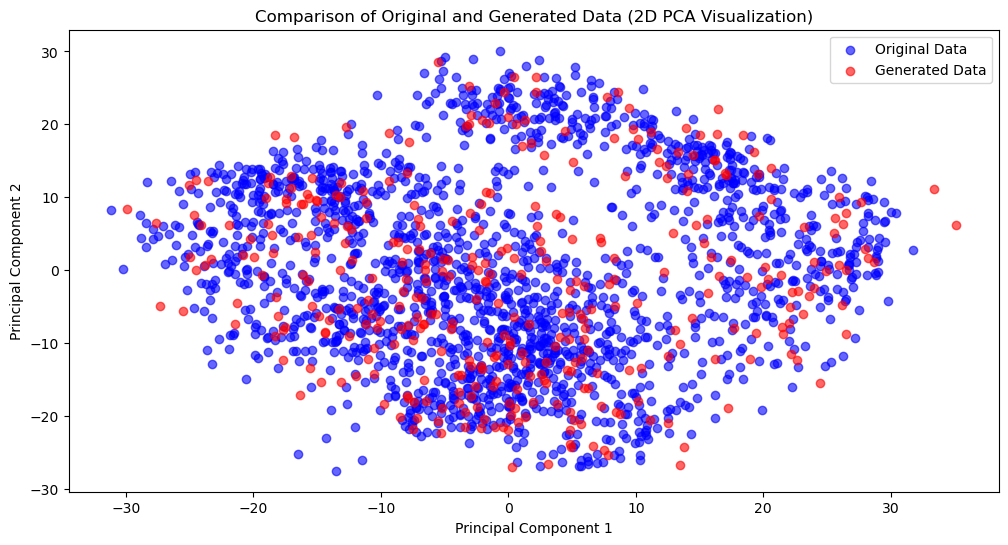

In [55]:
original_data =  digits.data


pca = PCA(n_components=2)
reduced_original_data = pca.fit_transform(original_data)
reduced_generated_data = pca.transform(generated_data)


plt.figure(figsize=(12, 6))

# Plot the original data in blue
plt.scatter(reduced_original_data[:, 0], reduced_original_data[:, 1], c='blue', label='Original Data', alpha=0.6)

# Plot the generated data in red
plt.scatter(reduced_generated_data[:, 0], reduced_generated_data[:, 1], c='red', label='Generated Data', alpha=0.6)

plt.title("Comparison of Original and Generated Data (2D PCA Visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc='best')
plt.show()

In [56]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity


data,target=ds.load_digits(return_X_y=True)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.1, random_state=42)
print(train_data.shape)
print(test_data.shape)
print(train_target.shape)
print(test_target.shape)

### single Gaussian
num_components = 1
gmm = GaussianMixture(n_components=num_components)
gmm.fit(train_data)
means = gmm.means_
covariances = gmm.covariances_
num_samples_to_generate = test_data.shape[0]
generated_data,_ = gmm.sample(num_samples_to_generate)


print("MMD for single Gaussian Modell:")
print("SE: ",compute_mmd(generated_data, test_data,sigma=0.1))
print("IMQ: ",compute_mmd(generated_data, test_data ,kernel=imq_kernel, sigma=100))

(1617, 64)
(180, 64)
(1617,)
(180,)
MMD for single Gaussian Modell:
SE:  0.105703284516338
IMQ:  0.10771265783261212


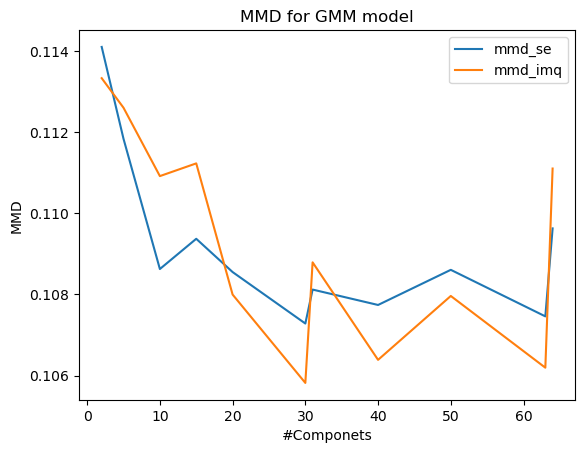

In [57]:
### GMM
num_components = np.array([2,5,10,15,20,30,31,40,50,63,64])
mmd_se=np.empty((num_components.shape[0],2))
mmd_imq=np.empty((num_components.shape[0],2))
for i in range(num_components.shape[0]):
    gmm = GaussianMixture(n_components=num_components[i])
    gmm.fit(train_data)
    means = gmm.means_
    covariances = gmm.covariances_
    num_samples_to_generate = test_data.shape[0]
    generated_data = gmm.sample(num_samples_to_generate)
    generated_samples, labels = generated_data
    mmd_se[i]=num_components[i],compute_mmd(generated_samples, test_data,sigma=10)
    mmd_imq[i]=num_components[i],compute_mmd(generated_samples, test_data ,kernel=imq_kernel, sigma=10)
plt.title("MMD for GMM model")
plt.xlabel("#Componets")
plt.ylabel("MMD")    
plt.plot(mmd_se[:,0],mmd_se[:,1],label="mmd_se")  
plt.plot(mmd_imq[:,0],mmd_imq[:,1],label="mmd_imq") 
plt.legend()

30 and 63 Components seem to be best.

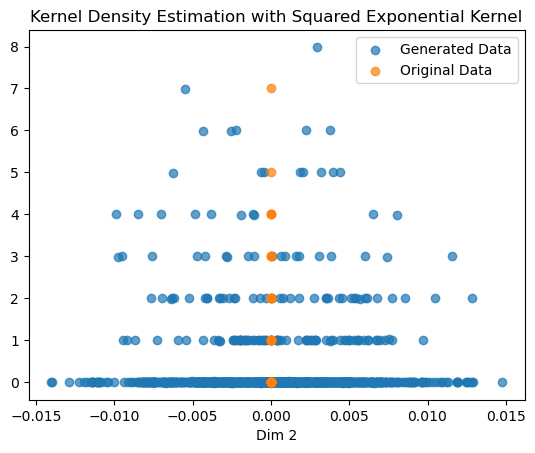

In [43]:
###KDE
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_blobs

# Fit KDE model with squared exponential kernel
kde = KernelDensity(kernel='gaussian', bandwidth=0.005) #smapeling not implemented for se Kernel...
kde.fit(train_data)

# Generate new samples from the KDE model
new_samples = kde.sample(1000)

# Plot the original and generated data for the first two dimensions

plt.scatter(new_samples[:, 0], new_samples[:, 1], label='Generated Data', alpha=0.7)
plt.scatter(test_data[:, 0], test_data[:, 1], label='Original Data', alpha=0.7)
plt.legend()
plt.xlabel("Dim 1")
plt.xlabel("Dim 2")
plt.title('Kernel Density Estimation with Squared Exponential Kernel')
plt.show()

<div style="color: green; font-weight: bold">
Very nice to see your visualization and model selection. However, it seems that you missed the KDTree model and forgot to compare the balance of predicted labels among generated samples from each generative model.
</div>